In [20]:
!pip install wfdb
!pip install padasip

#https://physionet.org/content/mitdb/1.0.0/


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import wfdb
import numpy as np
import padasip as pa
#wfdb.io.dl_database('mitdb', './mitdb', records='all', annotators='all', keep_subdirs=True, overwrite=False)

#Implementación de los filtros sugeridos en el paper (implementación I)

In [217]:
#Filtramos el wandering noise
def filter_wandering_noise(sig):
    d = np.ones(len(sig))
    filt_size = 1
    y, e, _= filter_with_LMS(d, sig, n = filt_size, m = 0.01)
    return e

def create_xhz_ref(length, freq, sr):

    N = 2*np.cos(2*np.pi*freq/sr)
    e = np.ones(length)
    e[0]=0.5
    for n in range(2, e.size):
        e[n] = N*e[n-1]-e[n-2]

    return e

def filter_60hz(signal, fs=360):
    ref = create_xhz_ref(len(signal), 60, 360) 
    y, e, w = filter_with_LMS(ref, signal, n = 2, m = 0.01)
    ref = create_xhz_ref(len(e), 120, 360) 
    y, e, w = filter_with_LMS(ref, e, n = 2, m = 0.01)
    return e

from ecgdetectors import Detectors

def detect_r_peak(sig):
    detectors = Detectors(360)
    r_peaks = np.array(detectors.christov_detector(sig))
    deltas = np.zeros(len(sig))
    deltas[r_peaks] = 1

    return deltas

def arf_filter(signal, filt_size, mu = 1):
    desired3 = signal
    deltas_og = detect_r_peak(desired3)
    offset = 150
    deltas = np.concatenate((np.zeros(offset),deltas_og))[:-offset]

    y, e, w = filter_with_NLMS(deltas, desired3, n = filt_size, m=mu)

    return e, y

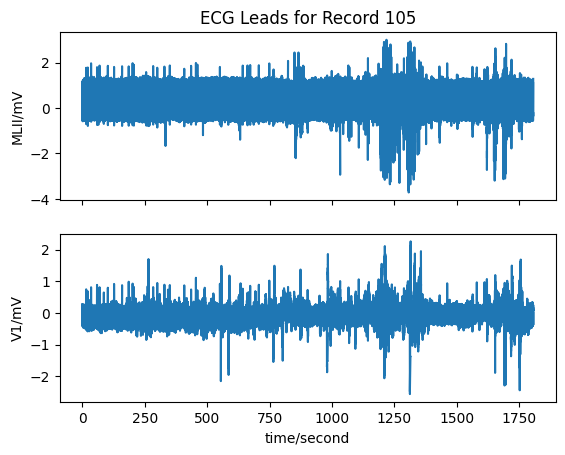

Record Name: 105
Number of Leads: 2
Sampling Frequency: 360 Hz
Record Duration: 1805.5555555555557 seconds
Lead Names: ['MLII', 'V1']


In [23]:
import wfdb
import matplotlib.pyplot as plt

# Load the ECG record from the MIT-BIH Arrhythmia Database
record_name = '105'  # Change this to the desired record name
record = wfdb.rdrecord(record_name, pn_dir='mitdb')

# Plot the ECG leads
wfdb.plot_wfdb(record=record, title=f'ECG Leads for Record {record_name}')
plt.show()

# Print additional information about the ECG record
record_info = wfdb.rdheader(record_name, pn_dir='mitdb')

print(f"Record Name: {record_info.record_name}")
print(f"Number of Leads: {record_info.n_sig}")
print(f"Sampling Frequency: {record_info.fs} Hz")
print(f"Record Duration: {record_info.sig_len / record_info.fs} seconds")
print(f"Lead Names: {record_info.sig_name}")

# You can access more information from the record_info object as needed.

In [159]:
def filter_with_NSSLMS(in_sig, desired_sig, n = 1, m = 0.01):
    # creation of data
    N = len(in_sig)
    filt_size =  n
    x = pa.input_from_history(in_sig,filt_size)
    d = desired_sig.reshape(len(desired_sig), 1)
    d = d[:N-filt_size+1, 0]

    f = pa.filters.FilterNSSLMS(n=filt_size, mu=m, w="zeros")
    y, e, w = f.run(d, x)
    
    return y, e , w   

def filter_with_SSLMS(in_sig, desired_sig, n = 1, m = 0.01):
    # creation of data
    N = len(in_sig)
    filt_size =  n
    x = pa.input_from_history(in_sig,filt_size)
    d = desired_sig.reshape(len(desired_sig), 1)
    d = d[:N-filt_size+1, 0]

    f = pa.filters.FilterSSLMS(n=filt_size, mu=m, w="zeros")
    y, e, w = f.run(d, x)
    
    return y, e , w   

def filter_with_LMS(in_sig, desired_sig, n = 1, m = 0.01):
    # creation of data
    N = len(in_sig)
    filt_size =  n
    x = pa.input_from_history(in_sig,filt_size)
    d = desired_sig.reshape(len(desired_sig), 1)
    d = d[:N-filt_size+1, 0]

    f = pa.filters.FilterLMS(n=filt_size, mu=m, w="zeros")
    y, e, w = f.run(d, x)
    
    return y, e , w   

def filter_with_NLMS(in_sig, desired_sig, n = 1, m = 0.01):
    # creation of data
    N = len(in_sig)
    filt_size =  n
    x = pa.input_from_history(in_sig,filt_size)
    d = desired_sig.reshape(len(desired_sig), 1)
    d = d[:N-filt_size+1, 0]

    f = pa.filters.FilterNLMS(n=filt_size, mu=m, w="zeros")
    y, e, w = f.run(d, x)
    
    return y, e , w   


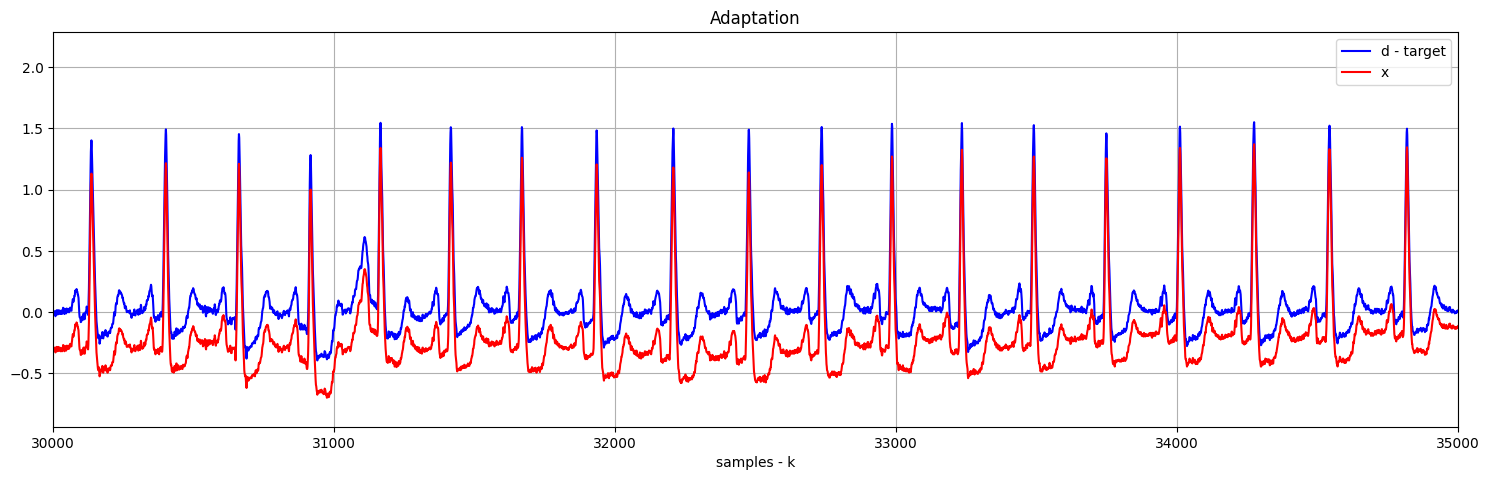

In [27]:
# Extract ECG data from two leads as numpy arrays
lead1_data = record.p_signal[:, 0]  # First lead
lead2_data = record.p_signal[:, 1]  # Second lead

N = len(lead1_data)//10
x = lead1_data[:N]

filtered_sig, _= filter_wandering_noise(x)

# show results
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(filtered_sig,"b", label="d - target");plt.legend()
plt.plot(x,"r", label="x");plt.legend()
plt.xlim(30e3, 35e3)
plt.tight_layout()
plt.grid()
plt.show()

# Filtro 60hz

In [28]:
import wfdb
import matplotlib.pyplot as plt

# Load the ECG record from the MIT-BIH Arrhythmia Database
record_name = '100'  # Change this to the desired record name
record = wfdb.rdrecord(record_name, pn_dir='mitdb')

# Print additional information about the ECG record
record_info = wfdb.rdheader(record_name, pn_dir='mitdb')




In [29]:
# Extract ECG data from two leads as numpy arrays
lead1_data = record.p_signal[:, 0]  # First lead
lead2_data = record.p_signal[:, 1]  # Second lead

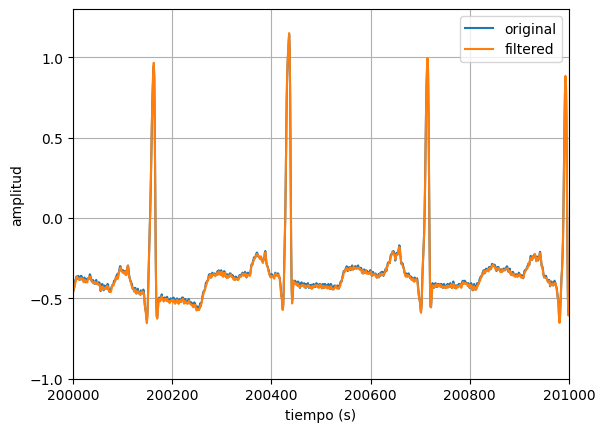

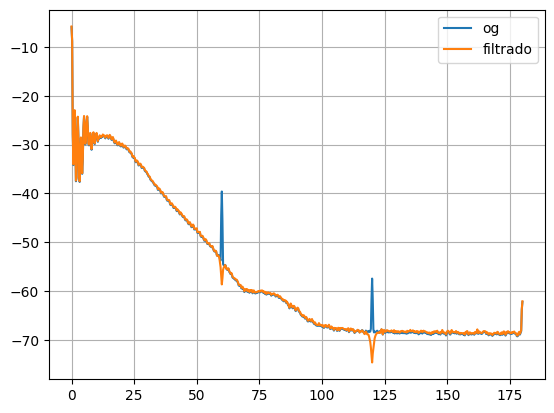

In [32]:
filtered = filter_60hz(lead1_data, 360)
plt.plot(lead1_data, label='original')
plt.plot(filtered, label='filtered')
plt.xlim(200000, 201000)
plt.legend()
plt.grid()
plt.ylim(-1,1.3)
plt.xlabel('tiempo (s)')
plt.ylabel('amplitud')
plt.show()

a, b = plt.mlab.psd(lead1_data, Fs=360, NFFT=360*4)
plt.plot(b,10*np.log10(a), label='og')
a, b = plt.mlab.psd(filtered, Fs=360, NFFT=360*4)
plt.plot(b,10*np.log10(a), label='filtrado')
plt.legend()
plt.grid()

plt.show()

# Implementación secuencial de los filtros:

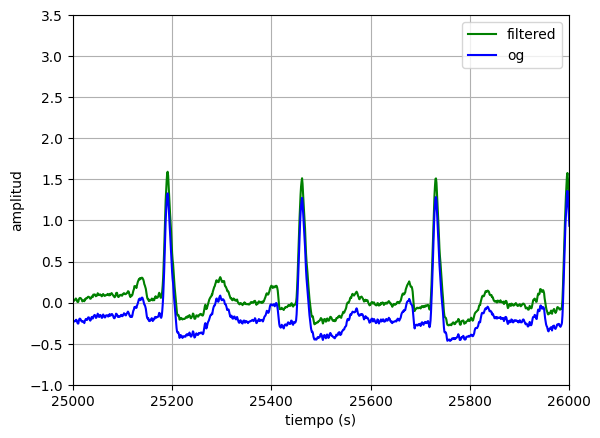

In [33]:
record_name = '105'  # Change this to the desired record name
record = wfdb.rdrecord(record_name, pn_dir='mitdb')

# Extract ECG data from two leads as numpy arrays
lead1_data = record.p_signal[:, 0]  # First lead
lead2_data = record.p_signal[:, 1]  # Second lead

N = len(lead1_data)//10
x = lead1_data[:N]

filtered_sig1, _ = filter_wandering_noise(x)

filtered_sig2 = filter_60hz(filtered_sig1, 360)

plt.plot(filtered_sig2, 'g', label='filtered')
plt.plot(x, 'b', label='og')
plt.xlim(25000, 26000)
plt.legend()
plt.grid()
plt.ylim(-1,3.5)
plt.xlabel('tiempo (s)')
plt.ylabel('amplitud')
plt.show()


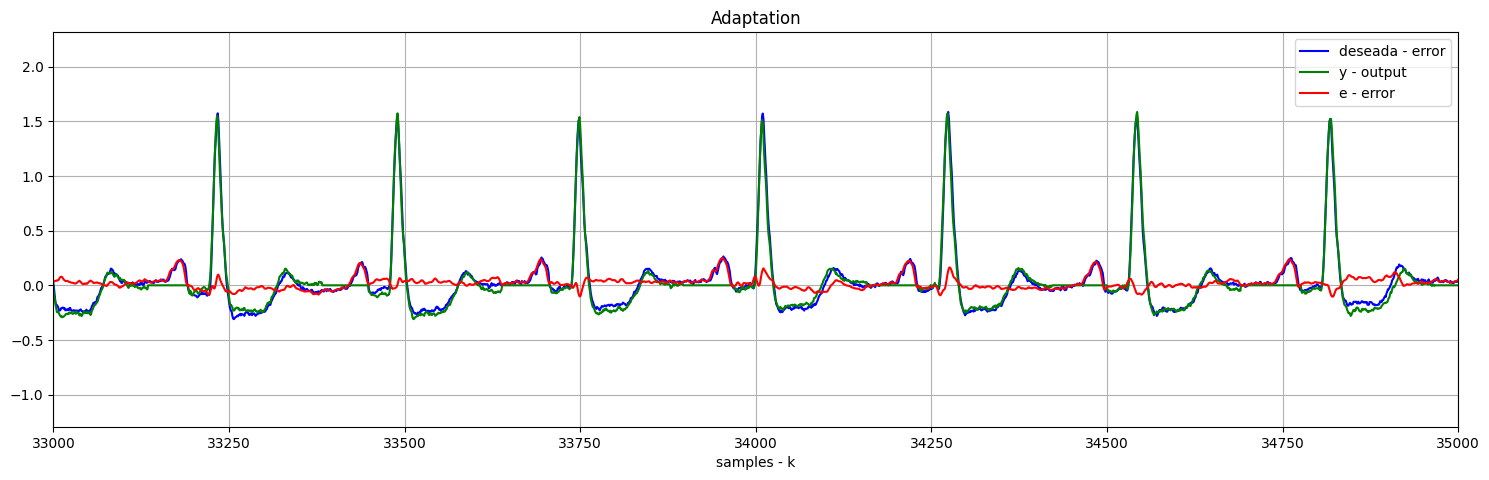

In [34]:
filt_size = 190
desired3 = filtered_sig2
deltas_og = detect_r_peak(desired3)
offset = 150
deltas = np.concatenate((np.zeros(offset),deltas_og))[:-offset]

y, e, w = filter_with_NLMS(deltas, desired3, n = filt_size, m = 1)

# show results
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")

plt.plot(desired3,"b", label="deseada - error");plt.legend()
plt.plot(y,"g", label="y - output");plt.legend()
plt.plot(np.convolve(e, np.ones(5), 'valid') / 5,"r", label="e - error");plt.legend()
plt.xlim(33e3, 35e3)
plt.tight_layout()
plt.grid()
plt.show()


# A continuación, un ejemplo de un latido ectópico

# Con la señal del tp4 de ASSD

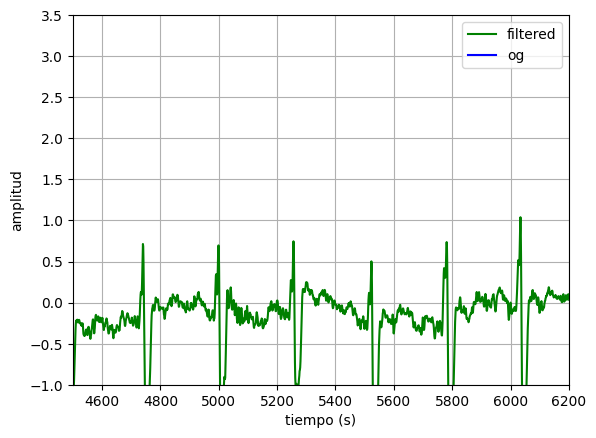

In [220]:
ecg_signal = np.loadtxt('test_ecg.csv')
N = len(ecg_signal)//3
x = ecg_signal[:N]

filtered_sig1 = filter_wandering_noise(x)

filtered_sig2 = filter_60hz(filtered_sig1, 360)

plt.plot(filtered_sig2, 'g', label='filtered')
plt.plot(x, 'b', label='og')
plt.xlim(4500, 6200)
plt.legend()
plt.grid()
plt.ylim(-1,3.5)
plt.xlabel('tiempo (s)')
plt.ylabel('amplitud')
plt.show()

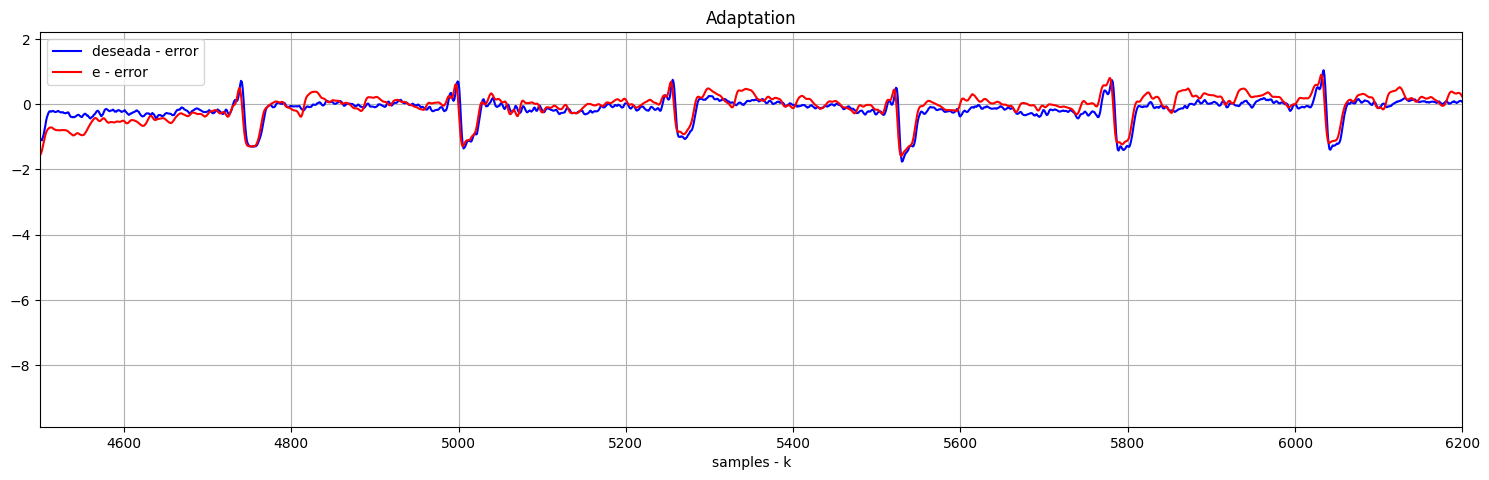

In [221]:
filt_size = 190
desired3 = filtered_sig2
deltas_og = detect_r_peak(desired3)
offset = 150
deltas = np.concatenate((np.zeros(offset),deltas_og))[:-offset]

y, e, w = filter_with_NLMS(deltas, desired3, n = filt_size, m = 0.4)

# show results
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")

plt.plot(desired3,"b", label="deseada - error");plt.legend()
#plt.plot(y,"g", label="y - output");plt.legend()
plt.plot(np.convolve(e, np.ones(5), 'valid') / 5,"r", label="e - error");plt.legend()
plt.xlim(5000, 6000)
plt.tight_layout()
plt.grid()
plt.show()

# Denoising

In [215]:
record_name = '212'
index = 71342
padding_right = 2000
padding_left = 20000

record2 = wfdb.rdrecord(record_name, pn_dir='mitdb', sampfrom = index-padding_left, sampto= index+padding_right)

# Extract ECG data from two leads as numpy arrays
lead1_data = record2.p_signal[:, 0]  # First lead
lead2_data = record2.p_signal[:, 1]  # Second lead


filtered_sig1 = filter_wandering_noise(lead1_data)

filtered_sig2 = filter_60hz(filtered_sig1, 360)

arf_error, filtered_sig3 = arf_filter(filtered_sig2, 250, mu=0.5)

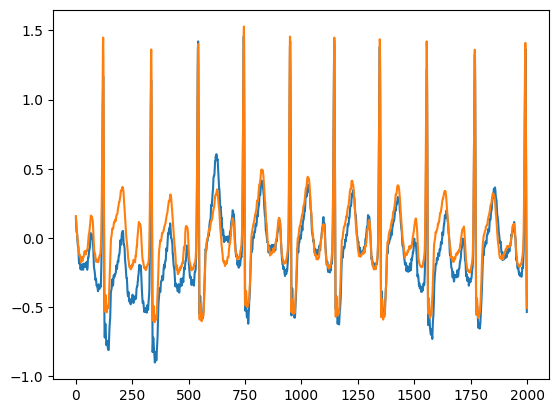

In [216]:
plt.plot(lead1_data[4500:6500])
plt.plot(filtered_sig3[4500:6500])


# Lectura de P-Wave annotations

In [126]:
#trato de identificar ECG con arritmias piolas

list_of_interest = ['R', 'x', 'S', '[', ']', '!']

list_of_interesting_ecgs = []


for j in range(100,234):
    try:
        annotations = wfdb.rdann('mitdb/'+str(j), extension='atr')
        # Access the annotation samples and symbols
        annotation_samples = annotations.sample
        annotation_symbols = annotations.symbol
        # Print the first 10 annotation samples and symbols
        for i in range(len(annotation_samples)):
            if (annotation_symbols[i])!='N':
                if (annotation_symbols[i]) in list_of_interest:
                    #print(f"Sample: {annotation_samples[i]}, Symbol: {annotation_symbols[i]}")
                    if j not in list_of_interesting_ecgs:
                        list_of_interesting_ecgs.append(j)
    except:
        pass


In [127]:
print(list_of_interesting_ecgs)

[108, 118, 124, 201, 207, 208, 212, 219, 231, 232]


In [134]:
annotations = wfdb.rdann('mitdb/'+str(212), extension='atr')
# Access the annotation samples and symbols
annotation_samples = annotations.sample
annotation_symbols = annotations.symbol
# Print the first 10 annotation samples and symbols
for i in range(len(annotation_samples)):
    if (annotation_symbols[i])!='N':
        if (annotation_symbols[i]) in list_of_interest:
            print(f"Sample: {annotation_samples[i]}, Symbol: {annotation_symbols[i]}")


Sample: 214, Symbol: R
Sample: 451, Symbol: R
Sample: 696, Symbol: R
Sample: 924, Symbol: R
Sample: 1168, Symbol: R
Sample: 1440, Symbol: R
Sample: 1707, Symbol: R
Sample: 1953, Symbol: R
Sample: 2191, Symbol: R
Sample: 2397, Symbol: R
Sample: 2604, Symbol: R
Sample: 2826, Symbol: R
Sample: 3049, Symbol: R
Sample: 3280, Symbol: R
Sample: 3548, Symbol: R
Sample: 3789, Symbol: R
Sample: 4030, Symbol: R
Sample: 4278, Symbol: R
Sample: 4516, Symbol: R
Sample: 4754, Symbol: R
Sample: 4976, Symbol: R
Sample: 5199, Symbol: R
Sample: 5438, Symbol: R
Sample: 5680, Symbol: R
Sample: 5917, Symbol: R
Sample: 6161, Symbol: R
Sample: 6398, Symbol: R
Sample: 6630, Symbol: R
Sample: 6854, Symbol: R
Sample: 7091, Symbol: R
Sample: 7333, Symbol: R
Sample: 7570, Symbol: R
Sample: 7813, Symbol: R
Sample: 8068, Symbol: R
Sample: 8331, Symbol: R
Sample: 8571, Symbol: R
Sample: 8806, Symbol: R
Sample: 9049, Symbol: R
Sample: 9280, Symbol: R
Sample: 9506, Symbol: R
Sample: 9741, Symbol: R
Sample: 9992, Symbol

In [222]:
record_name = '212'
index = 71342
padding_right = 2000
padding_left = 10000

record2 = wfdb.rdrecord(record_name, pn_dir='mitdb', sampfrom = index-padding_left, sampto= index+padding_right)

#wfdb.plot_wfdb(record=record2, title=f'ECG Leads for Record {record_name}')


Procesamos una señal de interés con AV block

In [234]:

# Extract ECG data from two leads as numpy arrays
lead1_data = record2.p_signal[:, 0]  # First lead
lead2_data = record2.p_signal[:, 1]  # Second lead


filtered_sig1 = filter_wandering_noise(lead2_data)

filtered_sig2 = filter_60hz(filtered_sig1, 360)

arf_error, filtered_sig3 = arf_filter(filtered_sig2, 250, 0.01)


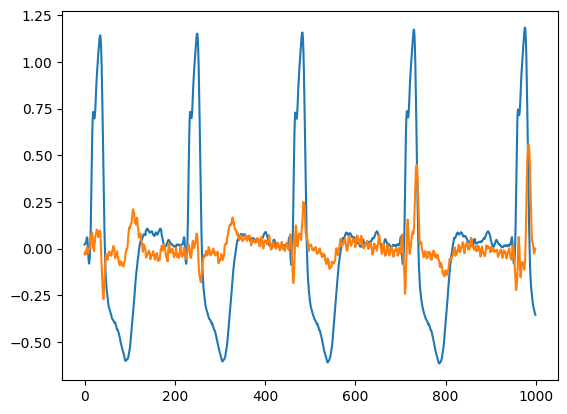

In [233]:
plt.plot(filtered_sig3[len(filtered_sig3)//2:len(filtered_sig3)//2+1000])
plt.plot((arf_error[len(filtered_sig3)//2:len(filtered_sig3)//2+1000]))